## Objective:
    
To make a theory calculation for the 2D (angular) cross correlation for the PanSTARRS Supernova and BOSS (CMASS & LOWZ) galaxy data sets, that was found previously for comparison and validation.

### Notes: 

- NIntegrate Chi integral in Mathematica

Author: Megan Tabbutt <br/>
Last Revised: 8_7_20

### Calculations:

_(2D) Cross Correlation Function (from Ross):_

$w(\theta)^{gg}_{ur} = b_u b_r \; \int \; n_u(z) n_r(z) \; \frac{dz}{d\chi} \frac{dz}{d\chi} \; d\chi \; \int \frac{k}{2 \pi} \; P(k, z(\chi)) \; J_0(\chi k \theta) \;dk $

Comoving distance formula from Dodelson:

$\chi(a) = \int^1_a \frac{da}{a^2H(a)}$ with $a = \frac{1}{1+z}$, $\chi(z) = \int^z_0 \frac{dz}{H(z)}$

and 

$H(z)^2 = H_0^2(\Omega_m(1+z)^3 + \Omega_k(1+z)^2 + \Omega_{\Lambda})$ (Wikipedia - Hubble Law)

In [26]:
# Working on 2015 laptop: Need to be in CCL conda environment to work on CAMB
import camb
import numpy as np
import pandas as pd
import sqlite3
import scipy as sp
import scipy.integrate
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
DATA_PATH = '/Users/megantabbutt/CosmologyDataProducts/'

In [42]:
# Define Cosmology:

Omega_m = .286
Omega_k = 0
Omega_L = .65193
hubble_0 = 69.6 # km/sec/Mpc
c = 3.0*(10**5) # km/sec

bias_gal = 1.0
bias_Sne = 1.0

### Pull in and Parse Data:

In [4]:
qry_PanSTARRS_Data_All = "SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (zSN > -999) || (zHost > -999)"

connPAN = sqlite3.connect(DATA_PATH + 'PanSTARRS.db')
PanSTARRSNEW_GoodZ = pd.read_sql(qry_PanSTARRS_Data_All, con=connPAN)
connPAN.close()
PanSTARRSNEW_GoodZ.head(3) # 1129 objects over 10 pointings 

,ID,DEC,RA,zSN,zHost
0,ps0909006,1.184831,333.9500,0.284,-999.0
1,ps0909010,-4.078911,37.1182,0.270,-999.0
2,ps0910017,-5.023289,35.2775,0.320,-999.0


##### Note: Take the redshift of the supernova if both are given. It redshift of supernova is unknown, take the redshift of the host. 

In [5]:
zBest = []
for i in PanSTARRSNEW_GoodZ.iterrows(): #.iterrows() returns a tuple (immutable object)
    if i[1]['zSN'] >= 0:
        zBest.append(i[1]['zSN'])
    else:
        zBest.append(i[1]['zHost'])
        
if PanSTARRSNEW_GoodZ.shape[0] == len(zBest):
    PanSTARRSNEW_GoodZ['zBest'] = zBest
    
PanSTARRSNEW_GoodZ.head(3)

,ID,DEC,RA,zSN,zHost,zBest
0,ps0909006,1.184831,333.9500,0.284,-999.0,0.284
1,ps0909010,-4.078911,37.1182,0.270,-999.0,0.270
2,ps0910017,-5.023289,35.2775,0.320,-999.0,0.320


In [46]:
type(PanSTARRSNEW_GoodZ['zBest'])

pandas.core.series.Series

In [60]:
Sne_z_all_hist = np.histogram(PanSTARRSNEW_GoodZ['zBest'], bins=40)
len(Sne_z_all_hist[0])
len(Sne_z_all_hist[1])

41

In [63]:
Sne_z_all_bin_centers = 0.5 * (Sne_z_all_hist[1][1:]+ Sne_z_all_hist[1][:-1])
Sne_z_all_bin_centers

array([0.03644463, 0.05933388, 0.08222313, 0.10511238, 0.12800163,
       0.15089088, 0.17378013, 0.19666938, 0.21955863, 0.24244788,
       0.26533713, 0.28822638, 0.31111563, 0.33400488, 0.35689413,
       0.37978338, 0.40267263, 0.42556188, 0.44845113, 0.47134038,
       0.49422963, 0.51711888, 0.54000813, 0.56289738, 0.58578663,
       0.60867588, 0.63156513, 0.65445438, 0.67734363, 0.70023288,
       0.72312213, 0.74601138, 0.76890063, 0.79178988, 0.81467913,
       0.83756838, 0.86045763, 0.88334688, 0.90623613, 0.92912538])

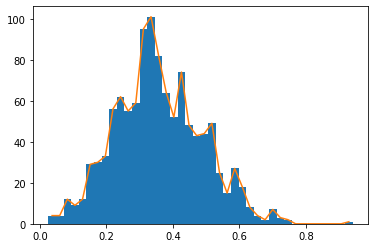

In [64]:
plt.hist(PanSTARRSNEW_GoodZ['zBest'], bins=40)
plt.plot(Sne_z_all_bin_centers, Sne_z_all_hist[0])
plt.show()

### Get chi(z) and interpolate to get z(chi):

In [6]:
# Need to get a list of zBest that is only unique entries:

zBest_unique = []
for i in zBest:
    if i not in zBest_unique:
        zBest_unique.append(i)
        
zBest_unique.sort()

In [7]:
hubble_z_inverse = lambda z: 1.0/(np.sqrt((hubble_0**2)*(Omega_m*(1 + z)**3 + Omega_k*(1 + z)**2 + Omega_L)))
# chi_z = scipy.integrate.quad(hubble_z_inverse, 0, zLimit)

chi_z_unique = []
for i in zBest_unique:
    zLimit = i
    chi_z__unique_tup = scipy.integrate.quad(hubble_z_inverse, 0, zLimit)
    chi_z_unique.append(chi_z__unique_tup[0]*c)

print("Redshift: " + str(zBest_unique[22]) + "      " + "Comoving Distance: " + str(chi_z_unique[22]))

Redshift: 0.101      Comoving Distance: 438.94375772270564


In [33]:
#z_chi_func = interp1d(chi_z_unique, zBest_unique, kind='cubic', fill_value="extrapolate")
z_chi_func = InterpolatedUnivariateSpline(chi_z_unique, zBest_unique, k=3)

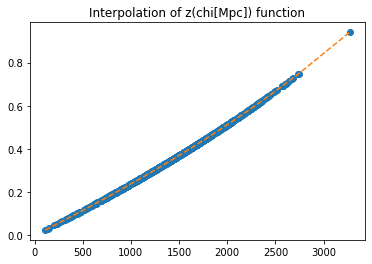

In [34]:
import matplotlib.pyplot as plt

plt.plot(chi_z_unique, zBest_unique, 'o')
plt.plot(chi_z_unique, z_chi_func(chi_z_unique), '--')
plt.title("Interpolation of z(chi[Mpc]) function")

plt.show()

In [37]:
z_chi_func_deriv = z_chi_func.derivative()
z_chi_func_deriv

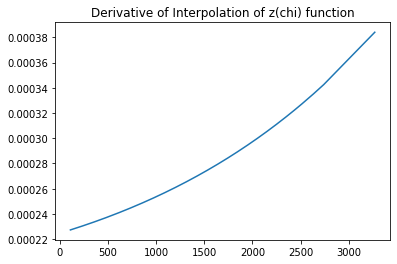

In [41]:
plt.plot(chi_z_unique, z_chi_func_deriv(chi_z_unique), '-')
plt.title("Derivative of Interpolation of z(chi) function")

plt.show()

In [20]:
from camb import model, initialpower

#Now get matter power spectra at redshift 0 and 1.0
params = camb.CAMBparams()
params.set_cosmology(H0=hubble_0, ombh2=0.0225, omch2=0.1431)
params.InitPower.set_params(ns=.96)

#Note non-linear corrections couples to smaller scales than you want
params.set_matter_power(redshifts=[0., 1.0], kmax=2.0)

#Linear spectra
params.NonLinear = model.NonLinear_none
results = camb.get_results(params)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)

Note: redshifts have been re-sorted (earliest first)


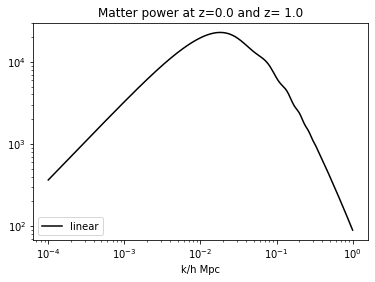

In [21]:
plt.loglog(kh, pk[i,:], color='k', ls = line)
plt.xlabel('k/h Mpc');
plt.legend(['linear'], loc='lower left');
plt.title('Matter power at z=%s and z= %s'%tuple(z));